<a href="https://colab.research.google.com/github/kexincchen/NLP-Assignment/blob/main/workshops/week7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workshop 07

In this workshop, we will learn how to implement attention mechanism in an RNN-based sequence model, the code is modified from [Official Doc of PyTorch](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html). The task we will focus on is question answering.



# 1. Download Dataset
The dataset we are using is the [chit-chat small talk datasets](https://github.com/microsoft/botframework-cli/blob/main/packages/qnamaker/docs/chit-chat-dataset.md). It provides the question-answer pairs for the ~100 scenarios, which are available for 5 pre-built personalities in 9 languages. In this example, we will use the English question-answer pairs of the chitchat personality.

In [ ]:
# Code to download file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


downloaded = drive.CreateFile({'id': '1AczfPH196NVsD8j9TwU-xN5XlBztEDy-'})
downloaded.GetContentFile('qna_chitchat_friendly.tsv')

import pandas as pd
df_friend = pd.read_csv('qna_chitchat_friendly.tsv', sep="\t")
df_friend.sample(10)

,Question,Answer,Source,Metadata
9130,I think I'm going to shoot myself,The National Suicide Prevention Lifeline is av...,qna_chitchat_Friendly,editorial:chitchat
6560,How was the day for you?,"Great, thanks for asking!",qna_chitchat_Friendly,editorial:chitchat
8338,I'm a girl,Okay.,qna_chitchat_Friendly,editorial:chitchat
7041,I'd love you to be my BFF,BFFs!,qna_chitchat_Friendly,editorial:chitchat
5564,You're making me laugh,You're laughing!,qna_chitchat_Friendly,editorial:chitchat
7701,This news left me exasperated,Oh no! I'm sorry to hear that.,qna_chitchat_Friendly,editorial:chitchat
5128,What a bad joke,My lack of comedy is tragic.,qna_chitchat_Friendly,editorial:chitchat
2635,What's your opinion of Cortana?,We're all trying to make life a little easier.,qna_chitchat_Friendly,editorial:chitchat
992,Lets go lunch,That's not one of my talents.,qna_chitchat_Friendly,editorial:chitchat
7472,Marry me,Definitely didn't see that coming!,qna_chitchat_Friendly,editorial:chitchat


In [ ]:
# Get the number of data instances (Q-A pairs)
n_data = df_friend.shape[0]

# 2. Preprocessing
Let's do some simple preprocessing on the raw data.

In [ ]:
# Get the question and answer list
question_list = df_friend['Question'].tolist()
answer_list = df_friend['Answer'].tolist()

# Have a look how they look like
print(question_list[:5])
print()
print(answer_list[:5])

['Lost the election because your speech was too boring', 'This is so dull', 'This is so uninteresting', 'U basic', 'Ugh so boring']

['Swing and a miss.', 'Swing and a miss.', 'Swing and a miss.', 'Swing and a miss.', 'Swing and a miss.']


In [ ]:
import re
import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize

# Have a look at some contractions of words! Contractions include punctuation - how would you handle them? There are many edge cases. i.e. can't, she'll
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have",
                    "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
                    "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did",
                    "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have",
                    "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have",
                    "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us",
                    "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have",
                    "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
                    "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
                    "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                    "so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                    "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                    "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not",
                    "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have",
                    "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have",
                    "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will",
                    "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
                    "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
                    "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

# the preprocessing techniques!
def pre_process(sent_list):
    output = []
    for sent in sent_list:
        sent = sent.lower() #case-folding
        for word, new_word in contraction_dict.items():
            sent = sent.replace(word, new_word) #dealing with contractions
        sent = re.sub(r'[^\w\s]','',sent) #removing punctuation
        output.append(word_tokenize(sent)) #tokenization
    return output

# Preprocessing the data using the function defined above
input_token_list = pre_process(question_list) # -> input to encoder
answer_token_list = pre_process(answer_list)

# Adding special tokens for generation: <BOS> indicates beginning of sentence, <EOS> means end o sentence.
output_token_list = [["<BOS>"] + s for s in answer_token_list] # -> input to decoder during the teacher-forcing training
target_token_list = [s + ["<EOS>"] for s in answer_token_list] # -> ground truth to be compared with the decoder output

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Here we simply use the maximum sentence length
MAX_LENGTH = max([len(s) for s in input_token_list] + [len(s) for s in target_token_list])

In [ ]:
# set up a vocab to index dictionary
word_to_ix = {"<BOS>": 0, "<EOS>":1}
for sentence in input_token_list+output_token_list:
    for word in sentence:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
word_list = list(word_to_ix.keys())

In [ ]:
# construct token index lists for input, output and target
# i.e., to convert each sequence into corresponding index based on the index dictionary we created in the previous section
# e.g., ['are', 'your', 'systems', 'functioning'] -> [42, 6, 2576, 2577]
def to_index(data, to_ix):
    input_index_list = []
    for sent in data:
        input_index_list.append([to_ix[w] for w in sent])
    return input_index_list

input_index = to_index(input_token_list, word_to_ix)
output_index = to_index(output_token_list, word_to_ix)
target_index = to_index(target_token_list, word_to_ix)

# 3. Model

Now, we will implement the RNN-based sequence model with attention, more specifically, using the GRU. It consists of a GRU encoder and a GRU decoder, between which the attention mechanism is applied. We can refer to the architecture of sequence with Attention from Lecture 12 (From Page 19).

*If you are not familiar with attention and the sequence model, going through the lecture 12 recording would be really helpful!*

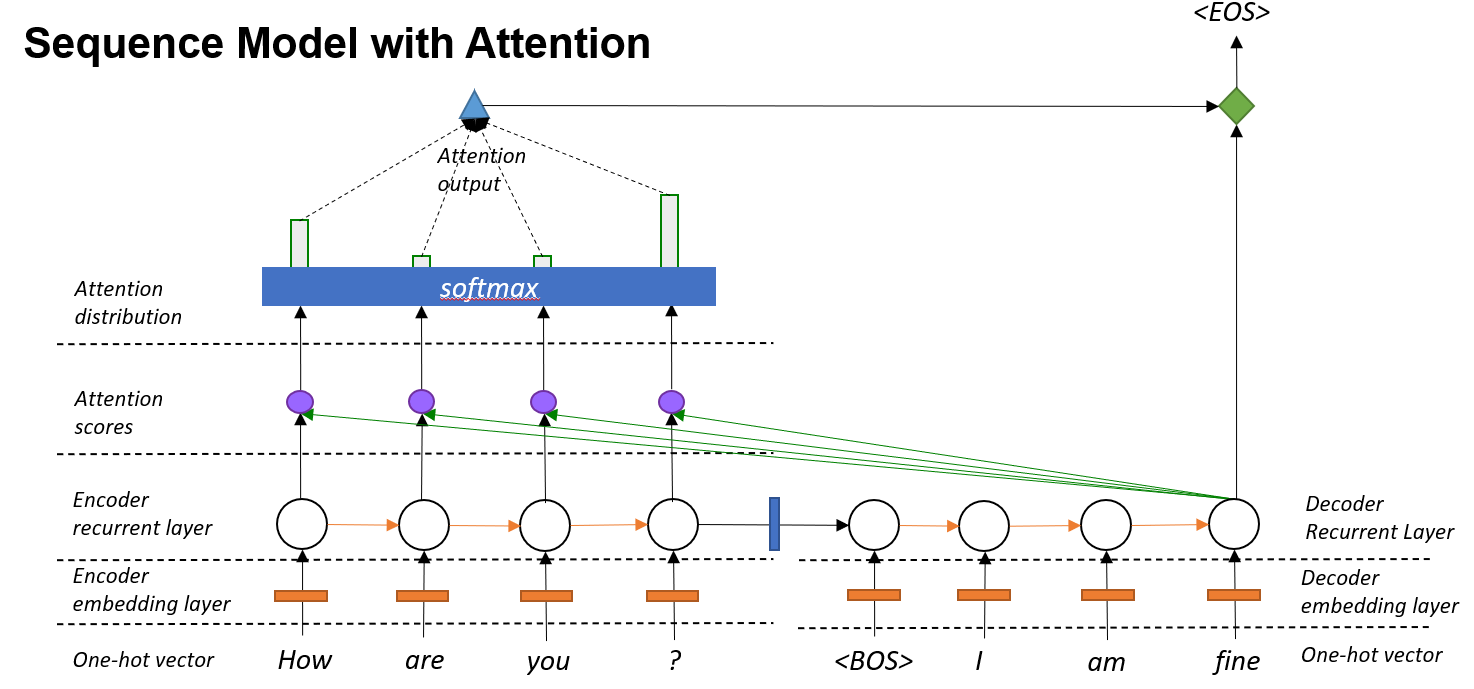

In [ ]:
import torch
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 3.1 Encoder

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = embedding
        # Here we use GRU (https://pytorch.org/docs/stable/generated/torch.nn.GRU.html)
        # you can easily replace it with other RNN-based variants such as the valina RNN or LSTM
        self.gru = nn.GRU(hidden_size, hidden_size)


    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## 3.2 Decoder

In [ ]:
class AttnDecoderRNN(nn.Module):
    ATTN_TYPE_DOT_PRODUCT = "Dot Product"
    # We will practise the scaled dot product attention in the exercise
    ATTN_TYPE_SCALE_DOT_PRODUCT = "Scale Dot Product"

    def __init__(self, hidden_size, output_size, embedding, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = embedding
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size*2, self.output_size)


    def cal_attention(self, hidden, encoder_hiddens, method):
        if method == AttnDecoderRNN.ATTN_TYPE_DOT_PRODUCT:
            # bmm: https://pytorch.org/docs/master/generated/torch.bmm.html (Performs a batch matrix-matrix product of matrices)
            attn_weights = F.softmax(torch.bmm(hidden, encoder_hiddens.T.unsqueeze(0)),dim=-1)
            attn_output = torch.bmm(attn_weights, encoder_hiddens.unsqueeze(0))
            concat_output = torch.cat((attn_output[0], hidden[0]), 1)

        return concat_output

    def forward(self, input, hidden, encoder_hiddens):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        _, hidden = self.gru(embedded, hidden)

        concat_output = self.cal_attention(hidden, encoder_hiddens, AttnDecoderRNN.ATTN_TYPE_DOT_PRODUCT)

        output = F.log_softmax(self.out(concat_output), dim=1)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## 3.3 Train Function

In [ ]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):


    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    # it is for storing the hidden states of input sequence later, which will be used for calculating the attention during the decoding process
    encoder_hiddens = torch.zeros(max_length, encoder.hidden_size, device=device)

    # zero-initialize an initial hidden state
    encoder_hidden = encoder.initHidden()

    loss = 0
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Feed the input_tensor into the encoder we defined
    for i in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[i], encoder_hidden)
        encoder_hiddens[i] = encoder_hidden[0, 0]

    # Use the <BOS> as the first token into decoder for generation
    decoder_input = torch.tensor([[word_to_ix["<BOS>"]]], device=device)

    decoder_hidden = encoder_hidden

    # Teacher forcing: Feed the target as the next input
    for i in range(target_length):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_hiddens)
        loss += criterion(decoder_output, target_tensor[i])
        decoder_input = target_tensor[i]

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

## 3.4 Train Iterations Function

In [ ]:
import time
import math

# Helper functions for training
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:
import random
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        random_choice_ix = random.choice(range(n_data)) # Get a random index within the scope of input data
        input_index_r = [[ind] for ind in input_index[random_choice_ix]]
        target_index_r = [[ind] for ind in target_index[random_choice_ix]]

        input_tensor = torch.LongTensor(input_index_r).to(device)
        target_tensor = torch.LongTensor(target_index_r).to(device)

        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0


# 4. Training Process

In [ ]:
hidden_size = 50
embedding = nn.Embedding(len(word_to_ix), hidden_size)
encoder1 = EncoderRNN(hidden_size, embedding).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, len(word_to_ix),embedding, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 10000, print_every=500)

0m 12s (- 3m 55s) (500 5%) 5.5397
0m 21s (- 3m 9s) (1000 10%) 3.7351
0m 34s (- 3m 15s) (1500 15%) 2.6949
0m 43s (- 2m 53s) (2000 20%) 2.1557
0m 52s (- 2m 37s) (2500 25%) 1.8350
1m 1s (- 2m 22s) (3000 30%) 1.6802
1m 9s (- 2m 9s) (3500 35%) 1.4262
1m 19s (- 1m 59s) (4000 40%) 1.2588
1m 28s (- 1m 48s) (4500 45%) 1.0582
1m 38s (- 1m 38s) (5000 50%) 1.0454
1m 47s (- 1m 27s) (5500 55%) 1.0138
1m 56s (- 1m 17s) (6000 60%) 0.8788
2m 5s (- 1m 7s) (6500 65%) 0.8653
2m 13s (- 0m 57s) (7000 70%) 0.7760
2m 22s (- 0m 47s) (7500 75%) 0.7116
2m 31s (- 0m 37s) (8000 80%) 0.7107
2m 41s (- 0m 28s) (8500 85%) 0.7061
2m 53s (- 0m 19s) (9000 90%) 0.6563
3m 1s (- 0m 9s) (9500 95%) 0.6547
3m 10s (- 0m 0s) (10000 100%) 0.6222


# 5. Evaluation

In [ ]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_sent = pre_process([sentence])[0]
        intput_index = [word_to_ix[word] for word in input_sent]
        input_tensor = torch.LongTensor([[ind] for ind in intput_index]).to(device)

        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_hiddens = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_hiddens[ei] += encoder_hidden[0, 0]

        decoder_input = torch.tensor([[word_to_ix["<BOS>"]]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_hiddens)
            topv, topi = decoder_output.data.topk(1) # simply adopt the predicted tag with the highest probabiity
            if topi.item() == word_to_ix["<EOS>"]: # if <EOS> is generated, stop the generation
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(word_list[topi.item()]) # get the predicted word based on the index
            # use the predicted output as the input for the next time step generation
            decoder_input = topi.squeeze().detach()

        return decoded_words

In [ ]:
sentence1 = "Are you in love with me?"
sentence2 = "Who do you love"
sentence3 = "Are you able to check my email?"
sentence4 = "You're the best"

print(evaluate(encoder1, attn_decoder1, sentence1, max_length=MAX_LENGTH))
print(evaluate(encoder1, attn_decoder1, sentence2, max_length=MAX_LENGTH))
print(evaluate(encoder1, attn_decoder1, sentence3, max_length=MAX_LENGTH))
print(evaluate(encoder1, attn_decoder1, sentence4, max_length=MAX_LENGTH))

['you', 'are', 'pretty', 'neat', '<EOS>']
['love', 'sounds', 'pretty', 'magical', '<EOS>']
['i', 'am', 'a', 'bot', 'who', 'was', 'created', 'by', 'humans', '<EOS>']
['i', 'am', 'a', 'bot', 'who', 'was', 'created', 'by', 'humans', '<EOS>']


# Workshop 7 Exercise
Please complete the following **exercise** for Workshop 7 and check with your Tutor.


## Exercise. Dot Product Attention VS. Scaled Dot Product Attention
Provided below is the implementation of the **Dot Product** attention. Please go through and try to change the **Dot Product** attention into **Scaled Dot Product** attention. You can refer to their definitions:



**Dot Product:**

![Dot_Product](https://drive.google.com/uc?id=1QtBgCp53e_6A_vzaMFEo89GJbTxnXagJ)

**Scaled Dot Product:**

![Scaled_Dot_Product](https://drive.google.com/uc?id=1v6n9WChBVfy0mBG2yxK9MUvGKzVGCmOt)





In [ ]:
class AttnDecoderRNN(nn.Module):
    ATTN_TYPE_DOT_PRODUCT = "Dot Product"
    ATTN_TYPE_SCALE_DOT_PRODUCT = "Scale Dot Product"

    def __init__(self, hidden_size, output_size, embedding, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = embedding
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size*2, self.output_size)


    def cal_attention(self, hidden, encoder_hiddens, method):
        # Dot Product Attention
        if method == AttnDecoderRNN.ATTN_TYPE_DOT_PRODUCT:
            # bmm: https://pytorch.org/docs/master/generated/torch.bmm.html
            attn_weights = F.softmax(torch.bmm(hidden, encoder_hiddens.T.unsqueeze(0)),dim=-1)
            attn_output = torch.bmm(attn_weights, encoder_hiddens.unsqueeze(0))
            concat_output = torch.cat((attn_output[0], hidden[0]), 1)
        # Scaled Dot Product Attention
        elif method == AttnDecoderRNN.ATTN_TYPE_SCALE_DOT_PRODUCT:
            # [TODO] COMPLETE THIS PART - Scaled Dot Product calculation method
            # Hint: - Try to think about what the n is about in the equation
            #       - Then, all you need to do is to apply the scaling (devided by the square-root of n) to the original score of the Dot Product Attention, before applying the softmax
            #       - Considering using np.sqrt() from numpy for conducting the non-negative square-root function
            attn_weights =
            attn_output =
            concat_output =

        return concat_output

    def forward(self, input, hidden, encoder_hiddens):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        _, hidden = self.gru(embedded, hidden)

        ## The following attention score calculation method is Dot Product for now
        ## It can be switched to Scaled Dot Product calculation method
        concat_output = self.cal_attention(hidden, encoder_hiddens, AttnDecoderRNN.ATTN_TYPE_DOT_PRODUCT)
        # concat_output = self.cal_attention(hidden, encoder_hiddens, AttnDecoderRNN.ATTN_TYPE_SCALE_DOT_PRODUCT)

        output = F.log_softmax(self.out(concat_output), dim=1)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

